Import Necessary Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
import numpy as np

# ETL (Extract, Transform, Load)

## Load and explore the dataset

### Geothermal Gradients Dataset

In [ ]:
gradients = pd.read_excel('data/Anexo 1. GRADIENTES GEOTÉRMICOS APARENTES.xlsx',sheet_name=1)
gradients = gradients.rename(columns={"Longitud": "Lon", "Latitud": "Lat"})
gradients.head()

### Moho Depth Dataset

In [ ]:
moho_depth = pd.read_csv('data/south-american-moho.txt', delim_whitespace=True, comment="#", header=None, names=["Latitude", "Longitude", "Moho Depth (m)"])
moho_depth = moho_depth.rename(columns={"Longitude": "Lon", "Latitude": "Lat"})
moho_depth.head()

### LAB depth dataset

In [ ]:
file_path = 'data/LithoRef18.xyz'

# Assuming your dataset is tab-separated (TSV) based on the format you provided.
# If it's a different format, you may need to adjust the delimiter or separator.
lab_depth = pd.read_table(file_path, delim_whitespace=True, header=None, names=[
    'LONG', 'LAT', 'ELEVATION', 'MOHO', 'LAB', 'RHO_C', 'RHO_L', 'RHO_SL',
    'BOTTOM', 'GEOID', 'FA', 'G_zz', 'G_xx', 'G_yy'
], skiprows=9)
lab_depth = lab_depth.rename(columns={"LONG": "Lon", "LAT": "Lat"})

lab_depth


### Volcanos

In [ ]:
volcanos = pd.read_csv('data/Volcanes_col.csv')
volcanos = volcanos.rename(columns={"X": "Lon", "Y": "Lat"})
volcanos.head()

## Data Preprocessing

### Moho Depth

We need to convert the Longitude from 0, 360° to -180°, 180°

In [ ]:
moho_depth["Lon"] = moho_depth["Lon"].apply(lambda x: x - 360 if x > 180 else x)

moho_depth.head()

Crop the moho_depth dataset so that it fits within the spatial extent of the first dataset (geothermal gradient).

In [ ]:
# Define the spatial extent boundaries from the "gradients" dataset
min_lat = gradients["Lat"].min()
max_lat = gradients["Lat"].max()
min_lon = gradients["Lon"].min()
max_lon = gradients["Lon"].max()

# Crop the "moho_depth" dataset to fit within the spatial extent of the "gradients" dataset
moho_depth= moho_depth[
    (moho_depth["Lat"] >= min_lat) & (moho_depth["Lat"] <= max_lat) &
    (moho_depth["Lon"] >= min_lon) & (moho_depth["Lon"] <= max_lon)
]

moho_depth.head()

In [ ]:
missing_values = moho_depth.isnull().sum()
missing_values

### LAB depth

In [ ]:
min_lat = gradients["Lat"].min()
max_lat = gradients["Lat"].max()
min_lon = gradients["Lon"].min()
max_lon = gradients["Lon"].max()

# Crop the "lab_depth" dataset to fit within the spatial extent of the "gradients" dataset
lab_depth= lab_depth[
    (lab_depth["Lat"] >= min_lat) & (lab_depth["Lat"] <= max_lat) &
    (lab_depth["Lon"] >= min_lon) & (lab_depth["Lon"] <= max_lon)
]

lab_depth.head()

In [ ]:
lab_depth.columns

### Gradients

In [ ]:
# Check for missing values
missing_values = gradients.isnull().sum()
missing_values

Remove rows without geothermal gradient, latitude or longitude values

In [ ]:
gradients = gradients.dropna(subset=["Gradiente Geotérmico Aparente (°C/Km)"])
gradients = gradients.dropna(subset=["Lat", "Lon"])

gradients.tail()

In [ ]:
missing_values = gradients.isnull().sum()
missing_values

In [ ]:
for col in gradients.columns:
    print(col)

### Volcanos

In [ ]:
missing_values = volcanos.isnull().sum()
missing_values

There's not much to do with volcanos dataset as they don't have missing Lon and Lat values.

## Feature Engineering

### Distance to nearest volcano

In [ ]:
import geopandas as gpd
from shapely.geometry import Point
import math

In [ ]:
# Load the "gradients" and "volcanos" datasets into GeoDataFrames
gradients_gdf = gpd.GeoDataFrame(gradients, geometry=gpd.points_from_xy(gradients['Lon'], gradients['Lat']))
volcanos_gdf = gpd.GeoDataFrame(volcanos, geometry=gpd.points_from_xy(volcanos['Lon'], volcanos['Lat']))

# Initialize an empty list to store distances to the nearest volcano (in meters)
distances_to_nearest_volcano = []

# Radius of the Earth in meters
earth_radius = 6371000  # Approximately

# Iterate through each well
for well in gradients_gdf.itertuples():
    nearest_volcano_distance = float('inf')  # Initialize with a large value
    
    # Iterate through each volcano to find the nearest one
    for volcano in volcanos_gdf.itertuples():
        # Haversine formula to calculate the great-circle distance
        lon1, lat1 = well.geometry.x, well.geometry.y
        lon2, lat2 = volcano.geometry.x, volcano.geometry.y

        dlon = math.radians(lon2 - lon1)
        dlat = math.radians(lat2 - lat1)

        a = math.sin(dlat/2)**2 + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon/2)**2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

        distance = earth_radius * c
        nearest_volcano_distance = min(nearest_volcano_distance, distance)
    
    distances_to_nearest_volcano.append(nearest_volcano_distance)

# Add the distances to the "gradients" dataset as a new column (in meters)
gradients['Distance_To_Nearest_Volcano (m)'] = distances_to_nearest_volcano

In [ ]:
gradients.head()

### Volcanos nearby (within radius = nearest volcano + 5 Km)

In [ ]:
import geopy.distance

# The radius is the distance to the nearest volcano plus 5000 meters (5 kilometers)
gradients['Radius (m)'] = gradients['Distance_To_Nearest_Volcano (m)'] + 5000

# Initialize an empty list to store the counts of nearby volcanoes
num_volcanoes_nearby = []

# Iterate through each well to count nearby volcanoes
for index, row in gradients.iterrows():
    well_location = (row['Lat'], row['Lon'])
    radius = row['Radius (m)']
    
    # Calculate the number of volcanoes within the specified radius
    num_nearby_volcanoes = len(volcanos[
        volcanos.apply(lambda x: geopy.distance.distance(well_location, (x['Lat'], x['Lon'])).m <= radius, axis=1)
    ])
    
    num_volcanoes_nearby.append(num_nearby_volcanoes)

# Add the "Number of Volcanoes Nearby" feature to the "gradients" dataset
gradients['Number of Volcanoes Nearby'] = num_volcanoes_nearby

# Verify the updated dataset
gradients.head()

### Moho Depth

In [ ]:
# Load the "gradients" and "moho_depth" datasets into GeoDataFrames
gradients_gdf = gpd.GeoDataFrame(gradients, geometry=gpd.points_from_xy(gradients['Lon'], gradients['Lat']))
moho_depth_gdf = gpd.GeoDataFrame(moho_depth, geometry=gpd.points_from_xy(moho_depth['Lon'], moho_depth['Lat']))

# Initialize an empty list to store Moho depth values for each well
moho_depth_values = []

# Iterate through each well
for well in gradients_gdf.itertuples():
    nearest_moho_depth = None
    
    # Iterate through each Moho depth location to find the nearest one
    for moho_location in moho_depth_gdf.itertuples():
        distance = well.geometry.distance(moho_location.geometry)
        
        if nearest_moho_depth is None or distance < nearest_moho_depth[0]:
            nearest_moho_depth = (distance, moho_location._3)  # Access the Moho depth attribute using dot notation
    
    # Append the Moho depth value to the list
    moho_depth_values.append(nearest_moho_depth[1] if nearest_moho_depth else None)

# Add the Moho depth values to the "gradients" dataset as a new column
gradients['Moho_Depth (m)'] = moho_depth_values

In [ ]:
gradients.head()

### LAB Depth

In [ ]:
# Create GeoDataFrames from datasets
gradients_gdf = gpd.GeoDataFrame(gradients, geometry=gpd.points_from_xy(gradients['Lon'], gradients['Lat']))
lab_depth_gdf = gpd.GeoDataFrame(lab_depth, geometry=gpd.points_from_xy(lab_depth['Lon'], lab_depth['Lat']))

# Initialize empty list to store lab depth values
lab_depth_values = []

for well in gradients_gdf.itertuples():
    nearest_lab_depth = None
    
    for lab_location in lab_depth_gdf.itertuples():
        distance = well.geometry.distance(lab_location.geometry)
        
        if nearest_lab_depth is None or distance < nearest_lab_depth[0]:
            nearest_lab_depth = (distance, lab_location.LAB)  # Use 'LAB' as the column name
    
    lab_depth_values.append(nearest_lab_depth[1] if nearest_lab_depth else None)

# Add the 'LAB' column to the gradients DataFrame
gradients['LAB'] = lab_depth_values

In [ ]:
# Define the columns to be added from lab_depth
columns_to_add = ['RHO_C', 'RHO_L', 'RHO_SL', 'FA', 'G_zz', 'G_xx', 'G_yy', 'LAB']

# Perform an inner join on 'LAB' to add the specified columns
gradients_2 = gradients.merge(lab_depth[columns_to_add], left_on='LAB', right_on='LAB', how='inner')

In [ ]:
gradients_2.head()

In [ ]:
gradients = gradients_2
gradients['LAB'] = gradients['LAB'].abs()

In [ ]:
gradients.head()

## Dataset cleaning

In [ ]:
# Replace "\n" with a space in column names
gradients.columns = gradients.columns.str.replace('\n', ' ')

In [ ]:
gradients.columns = gradients.columns.str.replace('  ', ' ')
gradients.columns = gradients.columns.str.replace('   ', ' ')

In [ ]:
gradients.head()

In [ ]:
# Convert "Profundidad BHT (ft)" to meters (1 ft = 0.3048 m)
gradients['Profundidad BHT (m)'] = gradients['Profundidad BHT (ft)'] * 0.3048

In [ ]:
gradients.columns

Select and rename columns

In [ ]:
columns_to_remove = ['UWI', 'Nombre del Pozo', 'Profundidad Total (ft)', 'Departamento', 'Cuenca', 'Coordenada X', 'Coordenada  Y', 'Elevación GL (ft)', 'BHT (°F)', 'BHT (°C)', 'Profundidad BHT (ft)', 'Profundidad BHT (m)', 'Temperatura de formación (°C)', 'Año de actualizacion del dato', 'Radius (m)']

cleaned_data = gradients.drop(columns=columns_to_remove)

In [ ]:
# Create a dictionary to map the Spanish column names to English column names
column_name_mapping = {
    'Lat': 'Latitude',
    'Lon': 'Longitude',
    'Elevacion (m)': 'Elevation (m)',
    'Temperatura en superficie (°C)': 'Surface Temperature (°C)',
    'Gradiente Geotérmico Aparente (°C/Km)': 'Apparent Geothermal Gradient (°C/Km)',
    'Distance_To_Nearest_Volcano (m)': 'Distance To Nearest Volcano (m)',
    'Number of Volcanoes Nearby': 'Number of Volcanoes Nearby',
    'Moho_Depth (m)': 'Moho Depth (m)',
    'LAB': 'LAB',
    'RHO_C': 'Crustal Density (kg/m³)',
    'RHO_L': 'Lithospheric Density (kg/m³)',
    'RHO_SL': 'Sub-Lithospheric Density (kg/m³)',
    'FA': 'Flexural Rigidity (Pa⁻¹)',
    'G_zz': 'Gravitational Acceleration z-component (m/s²)',
    'G_xx': 'Gravitational Acceleration x-component (m/s²)',
    'G_yy': 'Gravitational Acceleration y-component (m/s²)'
}

# Rename the columns using the dictionary
cleaned_data = cleaned_data.rename(columns=column_name_mapping)

In [ ]:
cleaned_data.head()

In [ ]:
# Save the DataFrame to a new CSV file
cleaned_data.to_csv('cleaned_data.csv', index=False)

In [ ]:
cleaned_data = pd.read_csv('cleaned_data.csv')
cleaned_data.head()

### Normalization of the data

Input data needs to be normalized as the features are in different scales. Target (heat flow) is not being normalized.

In [ ]:
cleaned_data.columns

In [ ]:
from sklearn.preprocessing import MinMaxScaler

columns_to_normalize = ['Elevation (m)', 'Surface Temperature (°C)',
                        'Distance To Nearest Volcano (m)', 'Number of Volcanoes Nearby',
                        'Moho Depth (m)', 'LAB', 'Crustal Density (kg/m³)',
                        'Lithospheric Density (kg/m³)', 'Sub-Lithospheric Density (kg/m³)',
                        'Flexural Rigidity (Pa⁻¹)',]

# Initialize the Min-Max scaler
scaler = MinMaxScaler()

# Fit and transform the selected columns
cleaned_data[columns_to_normalize] = scaler.fit_transform(cleaned_data[columns_to_normalize])

# Save the normalized data to a new CSV file
cleaned_data.to_csv('normalized_data_minmax.csv', index=False)

In [ ]:
cleaned_data.head()

## Read the normalized dataset

In [90]:
cleaned_data = pd.read_csv('normalized_data_minmax.csv')
cleaned_data.head()

,Latitude,Longitude,Elevation (m),Surface Temperature (°C),Apparent Geothermal Gradient (°C/Km),Distance To Nearest Volcano (m),Number of Volcanoes Nearby,Moho Depth (m),LAB,Crustal Density (kg/m³),Lithospheric Density (kg/m³),Sub-Lithospheric Density (kg/m³),Flexural Rigidity (Pa⁻¹),Gravitational Acceleration z-component (m/s²),Gravitational Acceleration x-component (m/s²),Gravitational Acceleration y-component (m/s²)
0,4.213002,-74.893581,0.100752,0.899248,14.712281,0.034231,0.142857,0.708538,1.0,0.717651,0.886783,0.780749,0.84464,1.03,-0.58,-0.45
1,4.216078,-74.888898,0.100557,0.899443,21.294394,0.034546,0.142857,0.708538,1.0,0.717651,0.886783,0.780749,0.84464,1.03,-0.58,-0.45
2,4.214720,-74.891220,0.101535,0.898465,23.783404,0.034375,0.142857,0.708538,1.0,0.717651,0.886783,0.780749,0.84464,1.03,-0.58,-0.45
3,5.830164,-74.321856,0.091949,0.908051,25.403742,0.079256,0.000000,0.540388,1.0,0.717651,0.886783,0.780749,0.84464,1.03,-0.58,-0.45
4,5.092486,-74.585899,0.054093,0.945907,37.921894,0.074201,0.142857,0.776304,1.0,0.717651,0.886783,0.780749,0.84464,1.03,-0.58,-0.45


In [91]:
cleaned_data.columns

Index(['Latitude', 'Longitude', 'Elevation (m)', 'Surface Temperature (°C)',
       'Apparent Geothermal Gradient (°C/Km)',
       'Distance To Nearest Volcano (m)', 'Number of Volcanoes Nearby',
       'Moho Depth (m)', 'LAB', 'Crustal Density (kg/m³)',
       'Lithospheric Density (kg/m³)', 'Sub-Lithospheric Density (kg/m³)',
       'Flexural Rigidity (Pa⁻¹)',
       'Gravitational Acceleration z-component (m/s²)',
       'Gravitational Acceleration x-component (m/s²)',
       'Gravitational Acceleration y-component (m/s²)'],
      dtype='object')

## Correlation Matrix

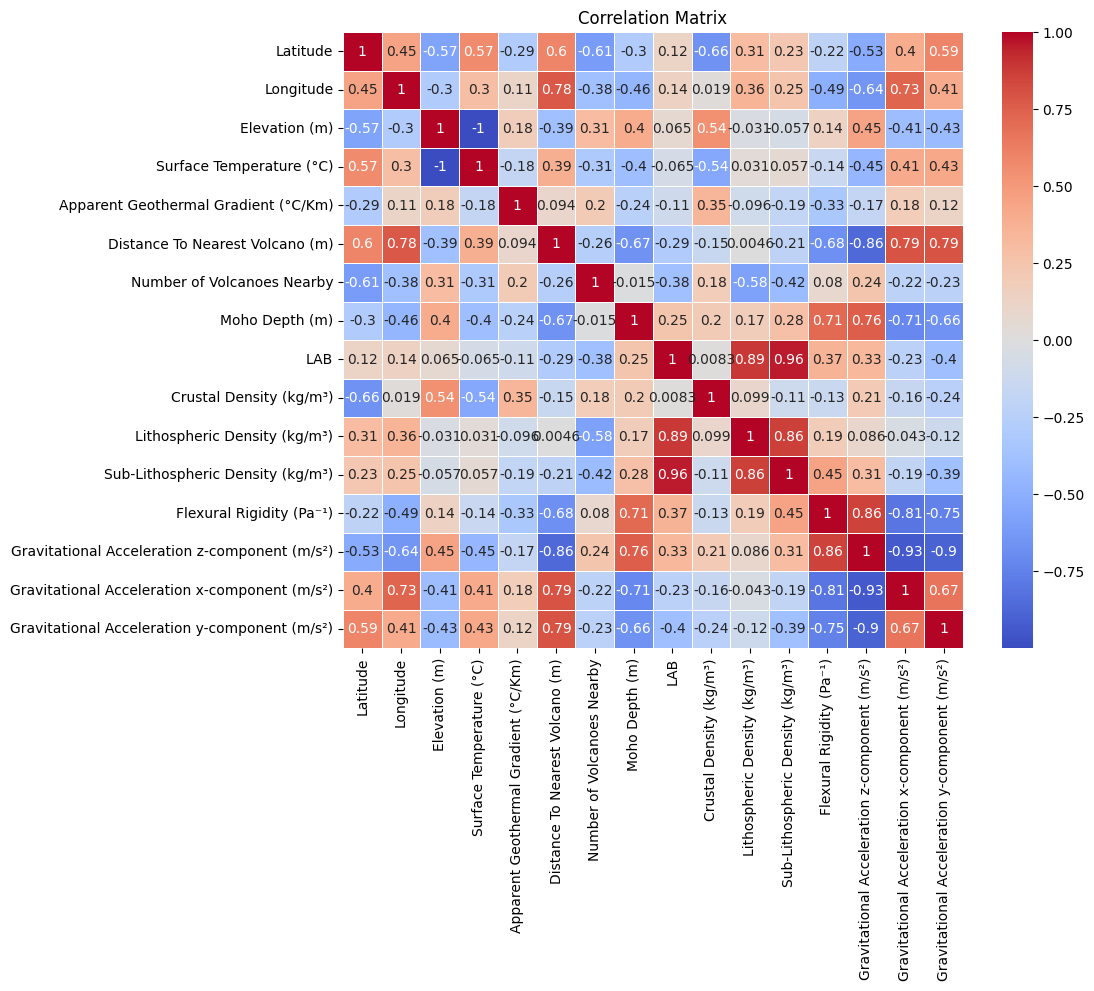

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select the desired columns
selected_columns = ['Latitude', 'Longitude', 'Elevation (m)', 'Surface Temperature (°C)',
       'Apparent Geothermal Gradient (°C/Km)',
       'Distance To Nearest Volcano (m)', 'Number of Volcanoes Nearby',
       'Moho Depth (m)', 'LAB', 'Crustal Density (kg/m³)',
       'Lithospheric Density (kg/m³)', 'Sub-Lithospheric Density (kg/m³)',
       'Flexural Rigidity (Pa⁻¹)',
       'Gravitational Acceleration z-component (m/s²)',
       'Gravitational Acceleration x-component (m/s²)',
       'Gravitational Acceleration y-component (m/s²)']

# Create a DataFrame with the selected columns
selected_data = cleaned_data[selected_columns]

# Calculate the correlation matrix
correlation_matrix = selected_data.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


# Building Machine Learning Algorythm

## Data Splitting

In [93]:
# Define feature matrix (X) and target variables (y)
X = cleaned_data[['Latitude', 'Longitude','Elevation (m)', 'Surface Temperature (°C)',
        'Distance To Nearest Volcano (m)', 'Number of Volcanoes Nearby',
        'Moho Depth (m)', 'LAB', 'Crustal Density (kg/m³)',
        'Lithospheric Density (kg/m³)', 'Sub-Lithospheric Density (kg/m³)',
        'Gravitational Acceleration z-component (m/s²)',
        'Gravitational Acceleration x-component (m/s²)',
        'Gravitational Acceleration y-component (m/s²)']]

y = cleaned_data['Apparent Geothermal Gradient (°C/Km)']

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save X_test with lat and lon for plotting later
X_test_with_lat_lon = X_test[['Latitude', 'Longitude']].copy()

# Save X with lat and lon for plotting later
X_lat_lon = X[['Latitude', 'Longitude']].copy()

# Remove lat and lon from X to predict on the whole dataset
X = X.drop(['Latitude', 'Longitude'], axis=1)

#Remove lat and lon from X_train and X_test
X_train = X_train.drop(['Latitude', 'Longitude'], axis=1)
X_test = X_test.drop(['Latitude', 'Longitude'], axis=1)

# Create DMatrix objects for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

## Hyperparameter Tuning with Cross-Validation

Manually iterating over hyperparameter combinations and recording the progress using the tqdm library. 

In [94]:
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001, 0.0001],
    'n_estimators': [100, 200, 300, 400, 500],  # Number of boosting rounds
    'subsample': [0.5, 0.6, 0.7],
    'colsample_bytree': [0.4, 0.5, 0.6],
    'min_child_weight': [0.5, 1.0, 3.0],
    'gamma': [0, 0.25, 0.5],
    'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
    'early_stopping_rounds': [10]  # Moved to the constructor
}

best_params = {}
best_mse = float('inf')

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Use tqdm to display a progress bar
for params in tqdm(list(ParameterGrid(param_grid))):
    xgb_model = xgb.XGBRegressor(**params)
    xgb_model.fit(X_train, y_train, 
                  eval_set=[(X_val, y_val)], 
                  verbose=False)
    y_pred = xgb_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    if mse < best_mse:
        best_params = params
        best_mse = mse

print("Best Hyperparameters:", best_params)
print("Best Mean Squared Error:", best_mse)


  0%|          | 0/29160 [00:00<?, ?it/s]

  0%|          | 38/29160 [00:11<2:23:37,  3.38it/s]


KeyboardInterrupt: 

## Train XGBoost and evaluate model

In [ ]:
best_xgb_model = xgb.XGBRegressor(**best_params)
best_xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.45, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.5, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05211635011119935,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=0.5, missing=nan, monotone_constraints=None,
             n_estimators=153, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Evaluate the model's performance on the test data using appropriate regression metrics (e.g., MAE, RMSE, R-squared).

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

y_pred = best_xgb_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

In [ ]:
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Absolute Error: 3.21911220537481
Root Mean Squared Error: 4.708113633818798
R-squared: 0.32876809346211155


MAE represents the average absolute difference between the predicted and actual values. A MAE of 2.9440 suggests that, on average, model's predictions are approximately 2.9440 °C/Km away from the true values. Lower MAE is generally better, but the "goodness" of the value depends on the context and domain knowledge.

RMSE measures the square root of the average squared differences between predicted and actual values. It penalizes larger errors more than MAE. RMSE of 4.4163 indicates that, on average, model's predictions deviate by approximately 4.4163 °C/Km from the true values. Smaller RMSE values are preferred.

R-squared, or the coefficient of determination, represents the proportion of the variance in the dependent variable that's predictable from the independent variables. An R² of 0.409 suggests that the model explains approximately 41.00% of the variance in the target variable. A higher R² value is desirable.

# Visualization of results

## Feature Importance Plot

Visualize the importance of each feature in the Random Forest model. This will help to understand which features have the most significant impact on predicting the geothermal gradient.

<Figure size 1000x600 with 0 Axes>

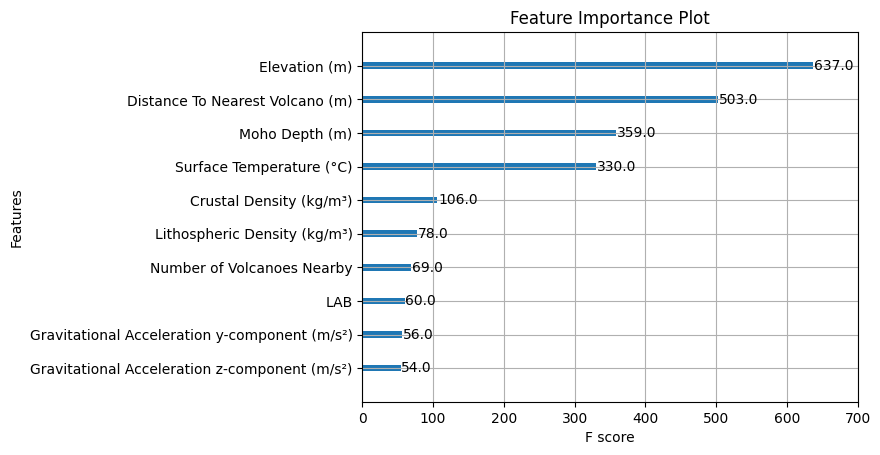

In [ ]:
# Fit an XGBoost model (best_params should contain your optimized hyperparameters)
xgb_model = xgb.XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)

# Plot feature importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10)
plt.title('Feature Importance Plot')
plt.show()

## Residual Plot

Create a residual plot to check if the model's predictions have a pattern. Most residuals must be near to zero

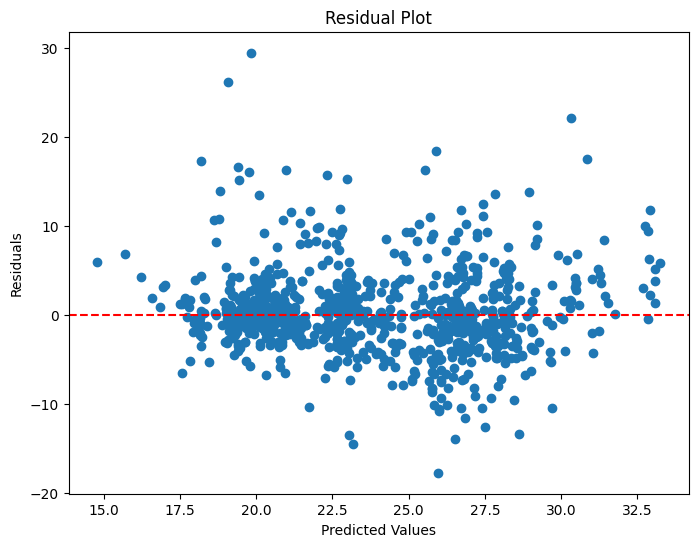

In [ ]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.show()

## Actual vs. Predicted Plot

Visualize how model's predictions compare to the actual values.

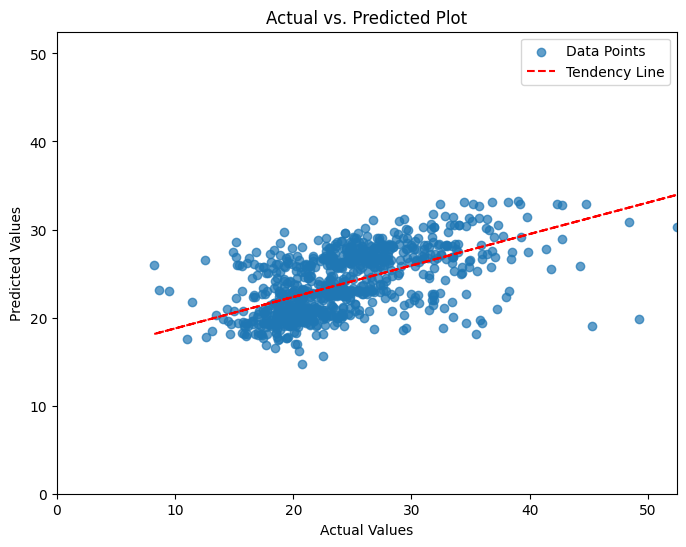

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, label='Data Points', alpha=0.7)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Plot')

# Set x and y axis limits to start at 0,0
plot_max = max(max(y_test), max(y_pred))
plt.xlim(0, plot_max)
plt.ylim(0, plot_max)

# Fit a linear regression line
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), color='red', linestyle='--', label='Tendency Line')

plt.legend()
plt.show()

## Partial Dependency Plots

Understand the relationship between a specific feature and the target while keeping other features constant.

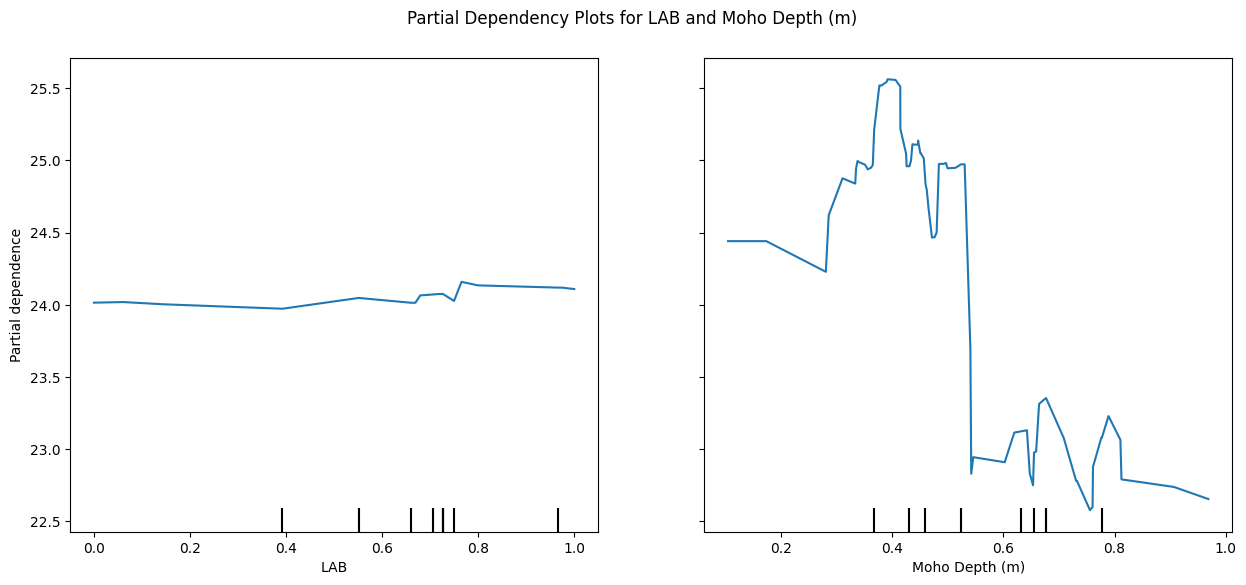

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

# Specify the feature names instead of using column indices
feature_names = ["LAB", "Moho Depth (m)"]

# Create partial dependency plots for the specified features
fig, ax = plt.subplots(figsize=(15, 6))
display = PartialDependenceDisplay.from_estimator(xgb_model, X_train, features=feature_names, ax=ax)
plt.subplots_adjust(top=0.9)  # Adjust the position of the subplots
display.figure_.suptitle('Partial Dependency Plots for LAB and Moho Depth (m)')  # Set the main title
plt.show()


## Geospatial visualization

### Actual data

In [ ]:
import geopandas as gpd

In [ ]:
actual_data = pd.read_csv('cleaned_data.csv')

### Predicted data

In [ ]:
# Make predictions using the entire dataset (X)
y_pred_full = xgb_model.predict(X)

# Update your existing DataFrame or create a new one to store the predictions
X_lat_lon['Predicted Geothermal Gradient (°C/Km)'] = y_pred_full

In [ ]:
X_lat_lon.head()

,Latitude,Longitude,Predicted Geothermal Gradient (°C/Km)
0,4.213002,-74.893581,25.325041
1,4.216078,-74.888898,25.325041
2,4.214720,-74.891220,25.325041
3,5.830164,-74.321856,26.661314
4,5.092486,-74.585899,27.517216


In [ ]:
X_lat_lon.to_csv('predicted_dataset.csv', index=False)

### Plot actual and predicted

/tmp/ipykernel_15017/1906445481.py:39: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


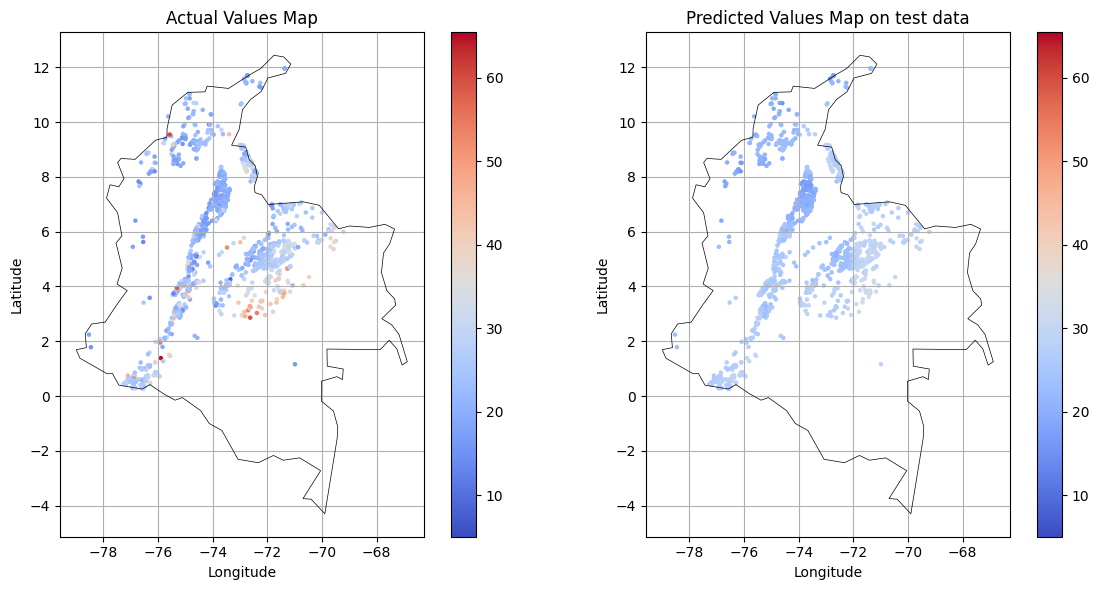

In [ ]:
# Load GeoDataFrame for actual values
actual_gdf = gpd.GeoDataFrame(actual_data, geometry=gpd.points_from_xy(actual_data['Longitude'], actual_data['Latitude']))

# Load GeoDataFrame for predicted values
predicted_gdf = gpd.GeoDataFrame(X_lat_lon, geometry=gpd.points_from_xy(X_lat_lon['Longitude'], X_lat_lon['Latitude']))

# Determine the common color range
vmin = min(actual_gdf['Apparent Geothermal Gradient (°C/Km)'].min(), predicted_gdf['Predicted Geothermal Gradient (°C/Km)'].min())
vmax = max(actual_gdf['Apparent Geothermal Gradient (°C/Km)'].max(), predicted_gdf['Predicted Geothermal Gradient (°C/Km)'].max())

# Create subplots with two axes
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot actual values on the first subplot
actual_plot = actual_gdf.plot(column='Apparent Geothermal Gradient (°C/Km)', cmap='coolwarm', markersize=5, legend=True, ax=axes[0], vmin=vmin, vmax=vmax)
axes[0].set_title('Actual Values Map')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

# Plot predicted values on the second subplot
predicted_plot = predicted_gdf.plot(column='Predicted Geothermal Gradient (°C/Km)', cmap='coolwarm', markersize=5, legend=True, ax=axes[1], vmin=vmin, vmax=vmax)
axes[1].set_title('Predicted Values Map on test data')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')

# Calculate grid positions based on min and max latitude and longitude
min_lon, max_lon = -78, -66
min_lat, max_lat = -4, 12
lon_grid = list(range(int(min_lon), int(max_lon) + 1, 2))
lat_grid = list(range(int(min_lat), int(max_lat) + 1, 2))

# Add gridlines for lat and lon to both subplots
for ax in axes:
    ax.set_xticks(lon_grid)
    ax.set_yticks(lat_grid)
    ax.grid()

# Load world country geometries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Subset the world dataset to only include countries within your area of interest
world = world.cx[-74:-73, 4:5]

# Plot country borders within your area of interest for both subplots
for ax in axes:
    world.boundary.plot(ax=ax, linewidth=0.5, color='black')

# Show the combined plot with both subplots
plt.tight_layout()
plt.show()


### Difference between actual and predicted

/tmp/ipykernel_15017/4261831172.py:23: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


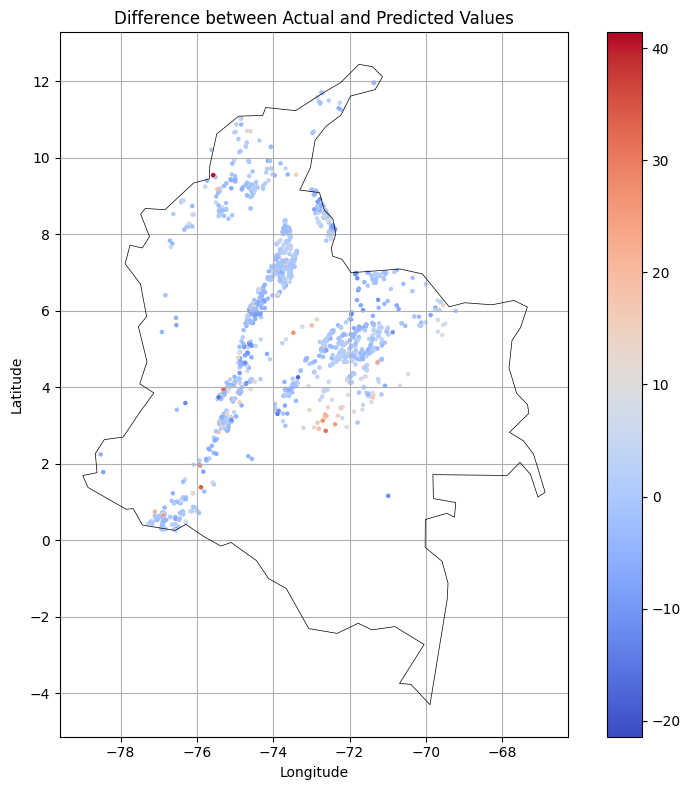

In [ ]:
# Calculate the difference between actual and predicted values
actual_gdf['Apparent Geothermal Gradient (°C/Km)'] = actual_gdf['Apparent Geothermal Gradient (°C/Km)'] - predicted_gdf['Predicted Geothermal Gradient (°C/Km)']

# Create a plot for the difference values
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
difference_plot = actual_gdf.plot(column='Apparent Geothermal Gradient (°C/Km)', cmap='coolwarm', markersize=5, legend=True, ax=ax)
ax.set_title('Difference between Actual and Predicted Values')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Calculate grid positions based on min and max latitude and longitude
min_lon, max_lon = -78, -66
min_lat, max_lat = -4, 12
lon_grid = list(range(int(min_lon), int(max_lon) + 1, 2))
lat_grid = list(range(int(min_lat), int(max_lat) + 1, 2))

# Add gridlines for lat and lon
ax.set_xticks(lon_grid)
ax.set_yticks(lat_grid)
ax.grid()

# Load world country geometries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Subset the world dataset to only include countries within your area of interest
world = world.cx[-74:-73, 4:5]

# Plot country borders within your area of interest
world.boundary.plot(ax=ax, linewidth=0.5, color='black')

# Show the plot
plt.tight_layout()
plt.show()
